In [2]:
import random
import numpy.random as rnd

from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle
import json

from scipy.integrate import odeint
import scipy.special as sps
import scipy.optimize as spo
from scipy.integrate import odeint
#import interp1d
from scipy.interpolate import interp1d

from jupyter_server import serverapp as app; 
import ipykernel, requests;

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')


plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 40

In [3]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)

In [4]:
import analysis.mathematical_functions.funcs as funcs

In [5]:
data_folder = project_path+'/data/parameter_runs/many_kappas/'
data_files = os.listdir(data_folder)
data_files = [data_folder+'/'+f for f in data_files if f.endswith('_feather')]
dataframes = [pd.read_feather(f) for f in data_files]

In [6]:
data_files

['../data/parameter_runs/many_kappas//01-10-19--04-06-2023abm_result_feather']

In [7]:
if len(dataframes)==1:
    datadf = dataframes[0]

In [8]:
datadf['first_tb'].unique()

array([29.47310585, 20.68064554,         inf, ..., 10.84717367,
        5.99631146,  3.10555556])

In [9]:
R0s = np.array(sorted(list(set(datadf['infection_rate']))))
mu_s = np.array(sorted(list(set(datadf['mutation_rate']))))
xi_s = np.array(sorted(list(set(datadf['xi']))))
kappa_s = np.array(sorted(list(set(datadf['kappa']))))
N = datadf['N'].unique()[0]

In [10]:
%load_ext autoreload

In [11]:
cwd = os.getcwd()
folder_name = cwd.split('/')[-1]

parallel_subfolder= 'results/parameter_runs/'+ folder_name
results_folder = os.path.relpath(project_path+'/'+parallel_subfolder)
os.makedirs(results_folder,exist_ok=True)

In [12]:
data_files[0][funcs.find_end_substring(data_files[0],parallel_subfolder)+1: data_files[0].find('abm')]

'ppas//01-10-19--04-06-2023'

In [13]:
if len(data_files)==1:
    dataname = data_files[0][data_files[0].find('//')+2:]
    results_name = results_folder+'/'+dataname
else:
    raise ValueError

In [14]:
filtered_df = datadf[~datadf.isin([np.inf, -np.inf]).any(axis=1)]

In [15]:
import scipy.io
import os

data = scipy.io.loadmat(os.getcwd()+'data/early_late_PD_with_sweeps.mat')

from itertools import product

In [16]:
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: Mac OS X x86 (64-bit), Created with the Wolfram Language for Students - Personal Use',
 '__version__': '1.0',
 '__globals__': [],
 'Expression1': array([array([[[[[[-1, -1, -1, ..., -1, -1, -1],
                   [-1, -1, -1, ..., -1, -1, -1],
                   [-1, -1, -1, ..., -1, -1, -1],
                   ...,
                   [-1, -1, -1, ..., -1, -1, -1],
                   [-1, -1, -1, ..., -1, -1, -1],
                   [-1, -1, -1, ..., -1, -1, -1]],
 
                  [[ 1,  1,  1, ...,  1,  1,  1],
                   [ 1,  1,  1, ...,  1,  1,  1],
                   [ 1,  1,  1, ...,  1,  1,  1],
                   ...,
                   [ 1,  1,  1, ...,  1,  1,  1],
                   [ 1,  1,  1, ...,  1,  1,  1],
                   [ 1,  1,  1, ...,  1,  1,  1]],
 
                  [[-1, -1, -1, ..., -1, -1, -1],
                   [-1, -1, -1, ..., -1, -1, -1],
                   [-1, -1, -1, ..., -1, -1, -1],
   

In [17]:
sweeps = data['Expression1'][-1]
R0_sweeps = sweeps[0]
kappa_sweeps= sweeps[1]
mu_sweeps = sweeps[2]
N_sweeps = sweeps[3]
dbar_sweeps = sweeps[4]
xi_sweeps = sweeps[5]
pd_data = data['Expression1'][0]
all_params = np.array(list(product(R0_sweeps, kappa_sweeps, mu_sweeps, N_sweeps, dbar_sweeps, xi_sweeps)))
pd_df = pd.DataFrame(all_params, columns = ['R0', 'kappa', 'mu', 'N', 'dbar', 'xi'])

pd_df['pd'] = pd_data.flatten()
pd_df['scaled_dbar'] = pd_df['dbar']/pd_df['xi']
pd_df['muN'] = pd_df['mu']*pd_df['N']

In [18]:
pd_df

,R0,kappa,mu,N,dbar,xi,pd,scaled_dbar,muN
0,1.5,10.0,0.000001,1.000000e+06,10.0,1.0,-1,10.000000,1.0
1,1.5,10.0,0.000001,1.000000e+06,10.0,10.0,-1,1.000000,1.0
2,1.5,10.0,0.000001,1.000000e+06,10.0,19.0,-1,0.526316,1.0
3,1.5,10.0,0.000001,1.000000e+06,10.0,28.0,-1,0.357143,1.0
4,1.5,10.0,0.000001,1.000000e+06,10.0,37.0,-1,0.270270,1.0
...,...,...,...,...,...,...,...,...,...
291595,9.5,1000.0,0.000100,1.000000e+10,50.0,64.0,-1,0.781250,1000000.0
291596,9.5,1000.0,0.000100,1.000000e+10,50.0,73.0,-1,0.684932,1000000.0
291597,9.5,1000.0,0.000100,1.000000e+10,50.0,82.0,-1,0.609756,1000000.0
291598,9.5,1000.0,0.000100,1.000000e+10,50.0,91.0,-1,0.549451,1000000.0


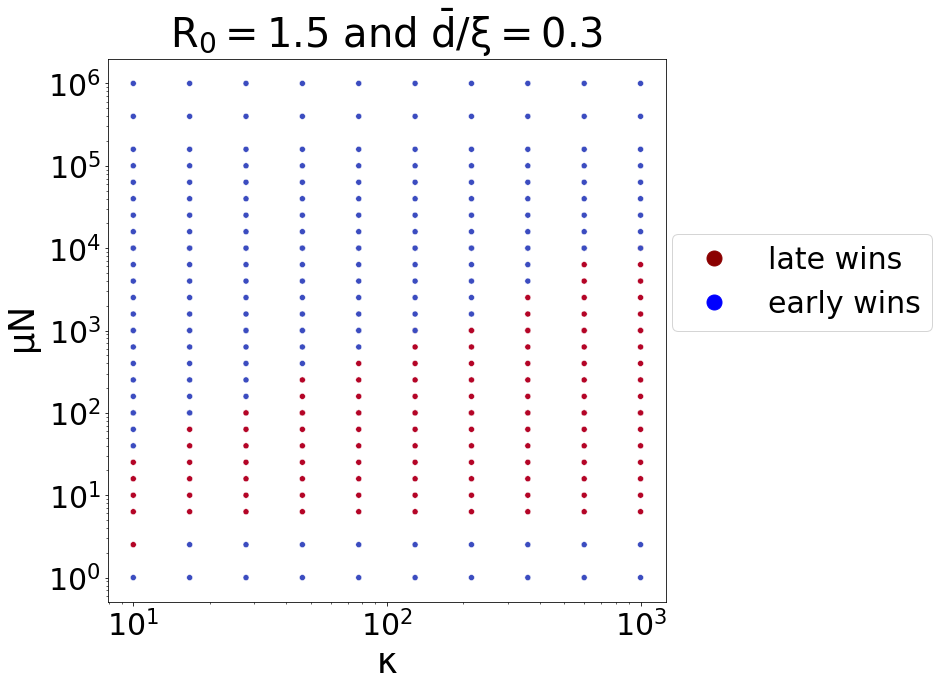

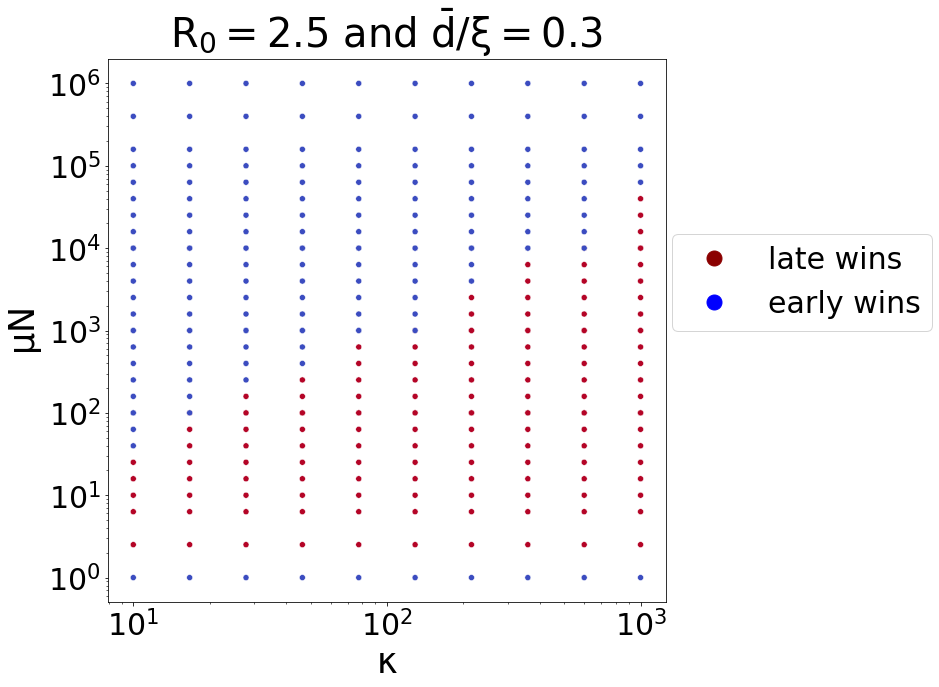

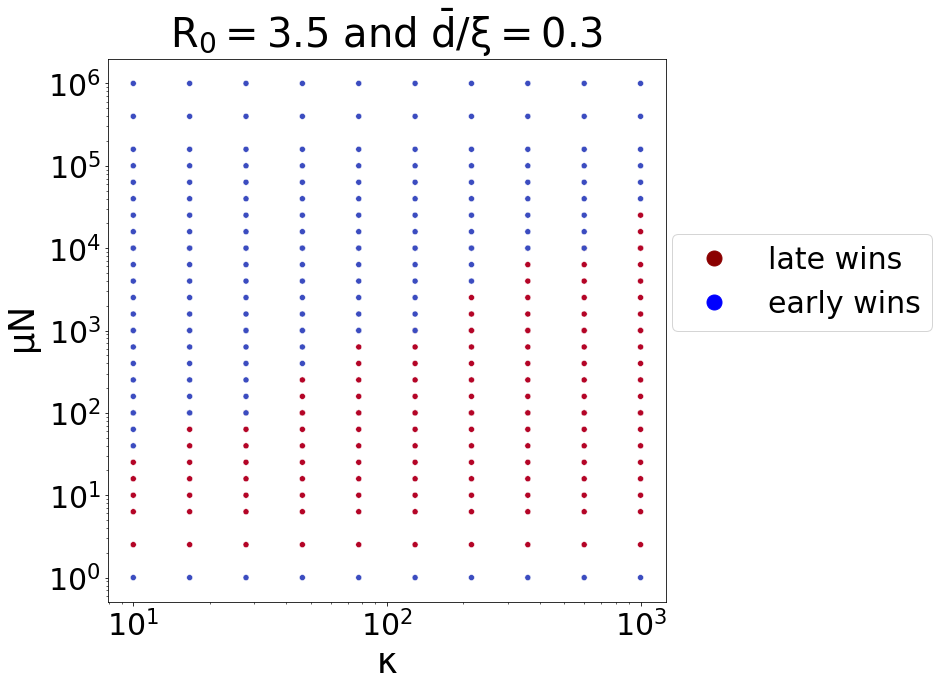

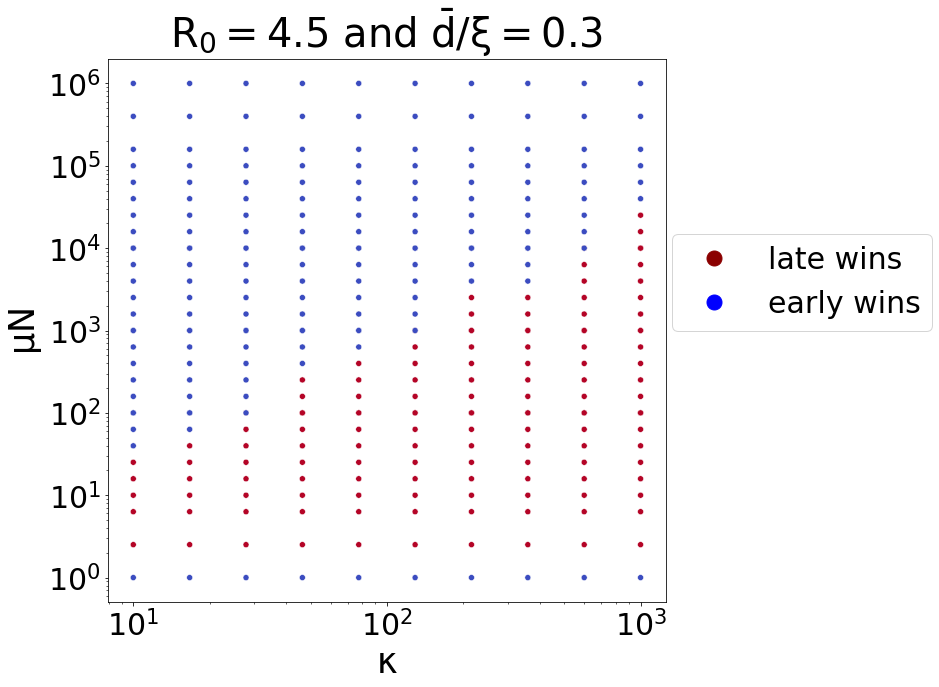

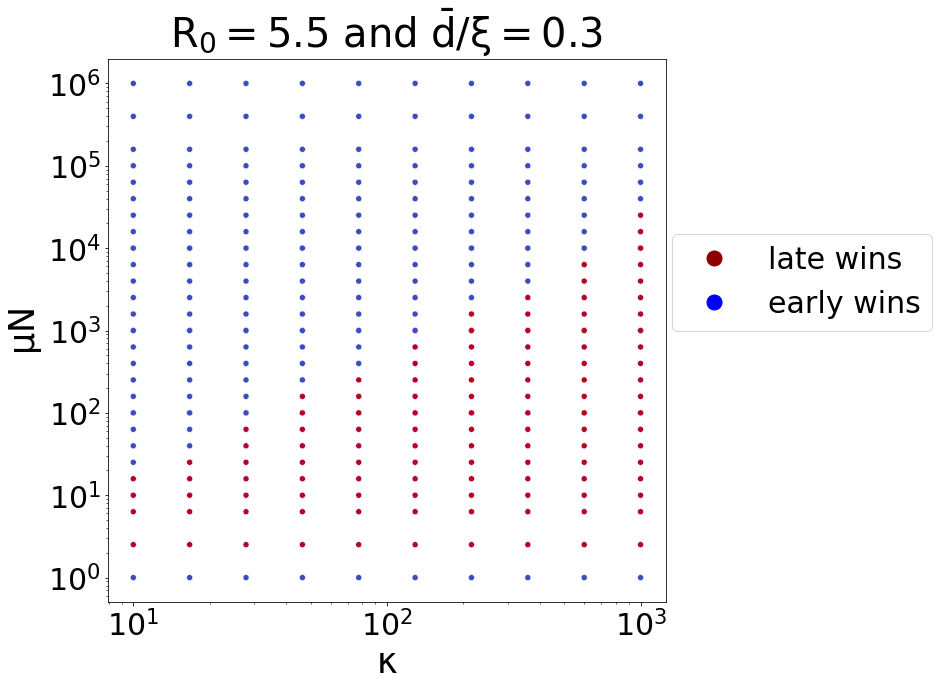

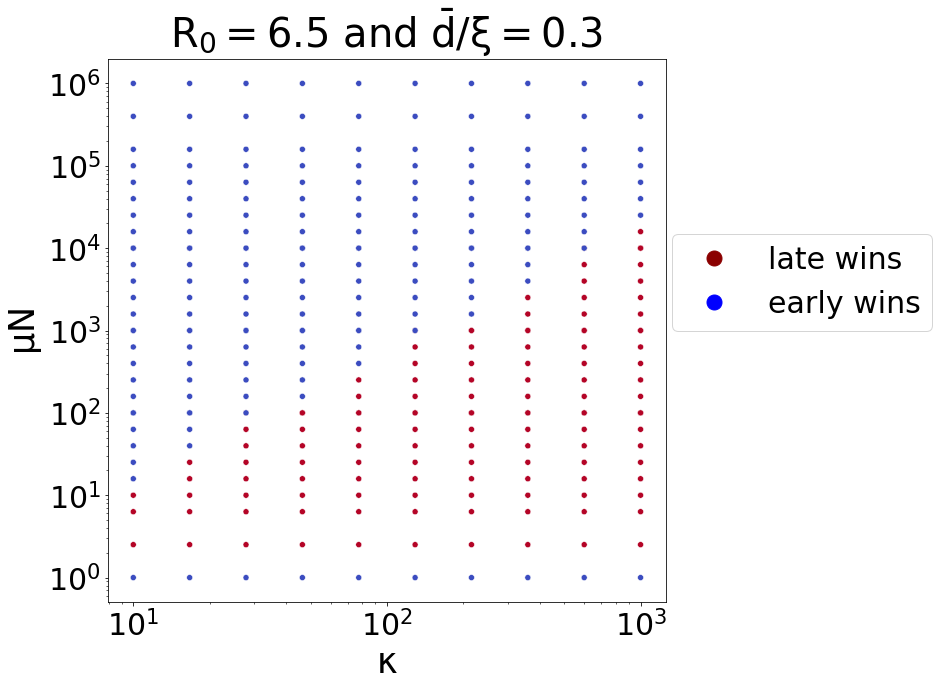

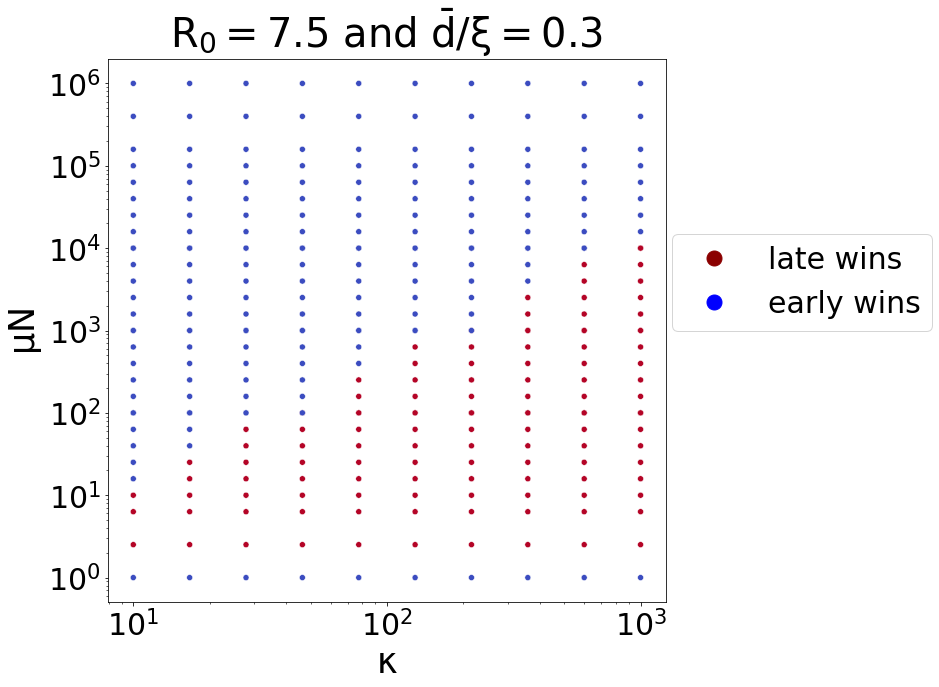

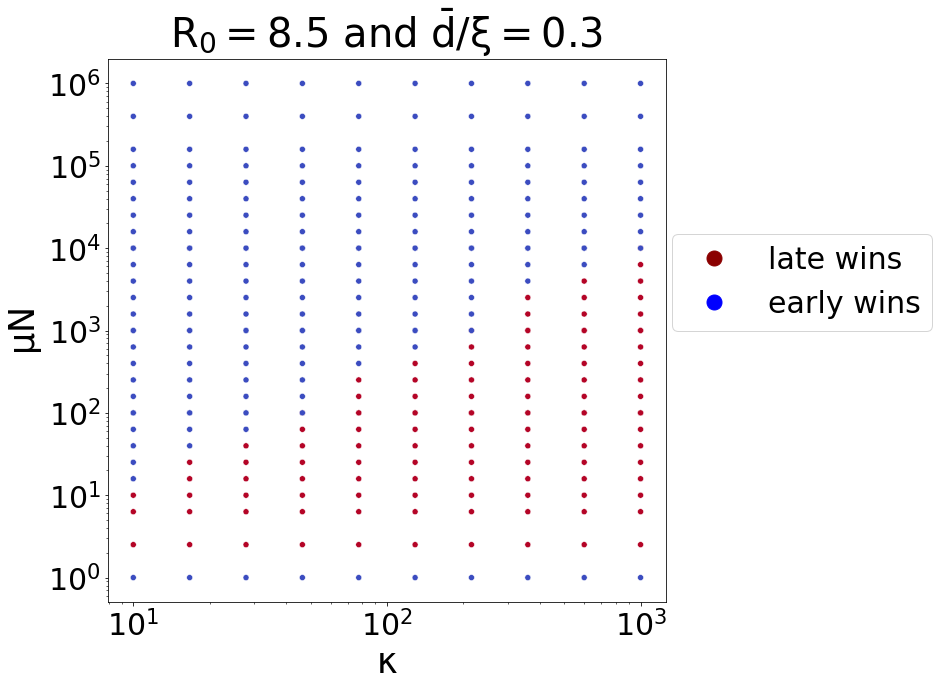

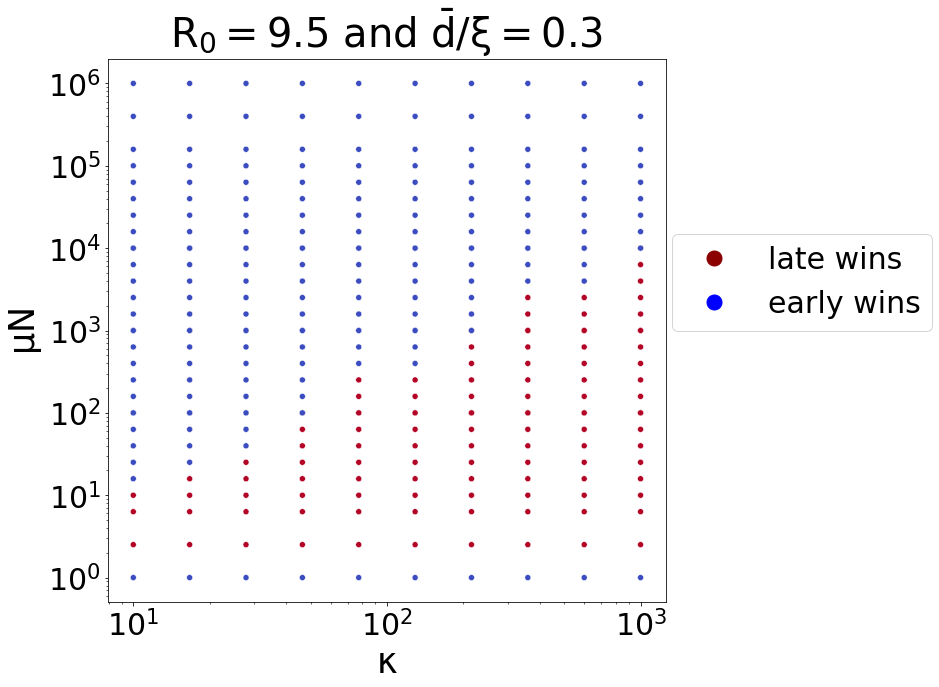

In [19]:
pd_df.query('R0==2.5 and scaled_dbar==0.5')
#plot phase diagram of muN vs kappa

R0 = 2.5
scaled_dbar= .3
for R0 in R0_sweeps:
    fig,ax= plt.subplots(figsize=(10,10))
    pd_plot = sns.scatterplot(data=pd_df.query(f'R0=={R0}and scaled_dbar=={scaled_dbar}'), x='kappa', y='muN', hue='pd', ax=ax, palette='coolwarm', legend=False)

    handles= [Line2D([0], [0], linestyle='', marker='o', color='darkred', label='late wins', markerfacecolor='darkred', markersize=15),
                Line2D([0], [0], linestyle='', marker='o', color='blue', label='early wins', markerfacecolor='blue', markersize=15)]
    ax.legend(handles=handles, loc=(1.01,0.5), fontsize=30)

    ax.set_xlabel(r'$\kappa$')
    ax.set_ylabel(r'$\mu N$')
    ax.set_title(rf'$R_0={R0}$ and $\bar{{d}}/\xi={scaled_dbar}$')
    ax.set_yscale('log')
    ax.set_xscale('log')


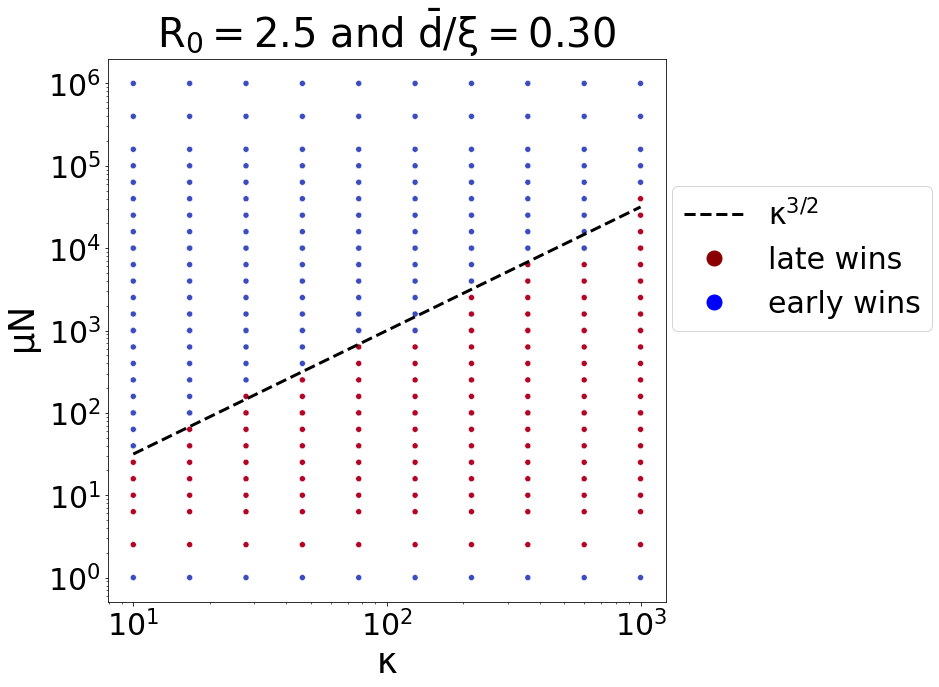

In [20]:
scaled_dbar = np.sort(pd_df['scaled_dbar'].unique())
R0 = 2.5

scaled_dbar = .3

fig,ax= plt.subplots(figsize=(10,10))

ax.plot(kappa_sweeps, kappa_sweeps**1.5, color='black', linestyle='--', label=r'$\kappa^{3/2}$')
pd_plot = sns.scatterplot(data=pd_df.query(f'R0=={R0}and scaled_dbar=={scaled_dbar}'), x='kappa', y='muN', hue='pd', ax=ax, palette='coolwarm', legend=False)
handles = [Line2D([0], [0], linestyle='--', color='black', label=r'$\kappa^{3/2}$')]
handles+= [Line2D([0], [0], linestyle='', marker='o', color='darkred', label='late wins', markerfacecolor='darkred', markersize=15),
            Line2D([0], [0], linestyle='', marker='o', color='blue', label='early wins', markerfacecolor='blue', markersize=15)]
ax.legend(handles=handles, loc=(1.01,0.5), fontsize=30)

ax.set_xlabel(r'$\kappa$')
ax.set_ylabel(r'$\mu N$')
ax.set_title(rf'$R_0={R0}$ and $\bar{{d}}/\xi={scaled_dbar:.2f}$')
ax.set_yscale('log')
ax.set_xscale('log')
    

In [21]:
scaled_dbar

0.3

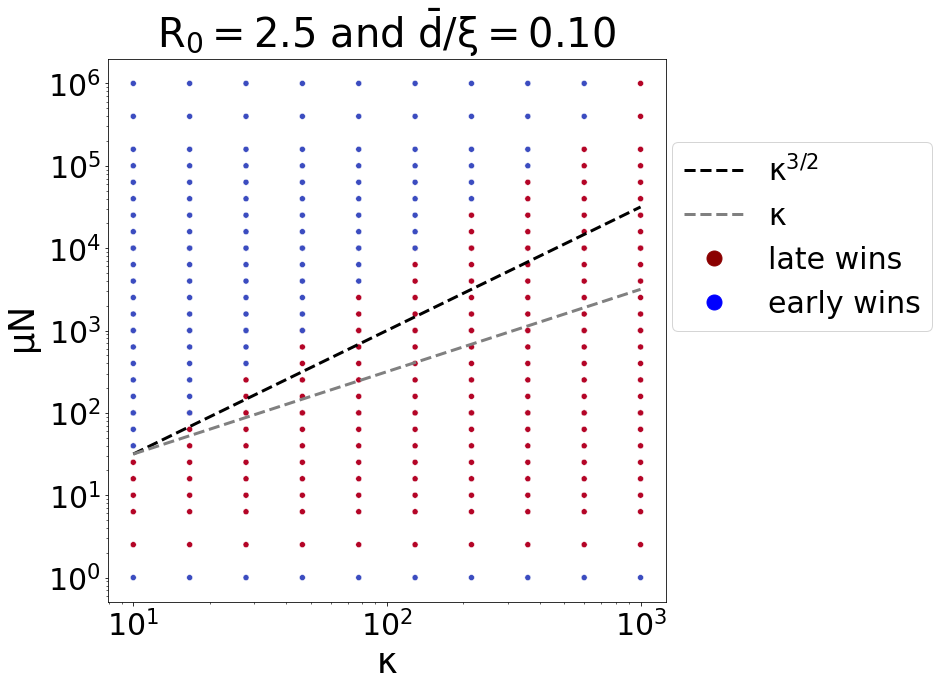

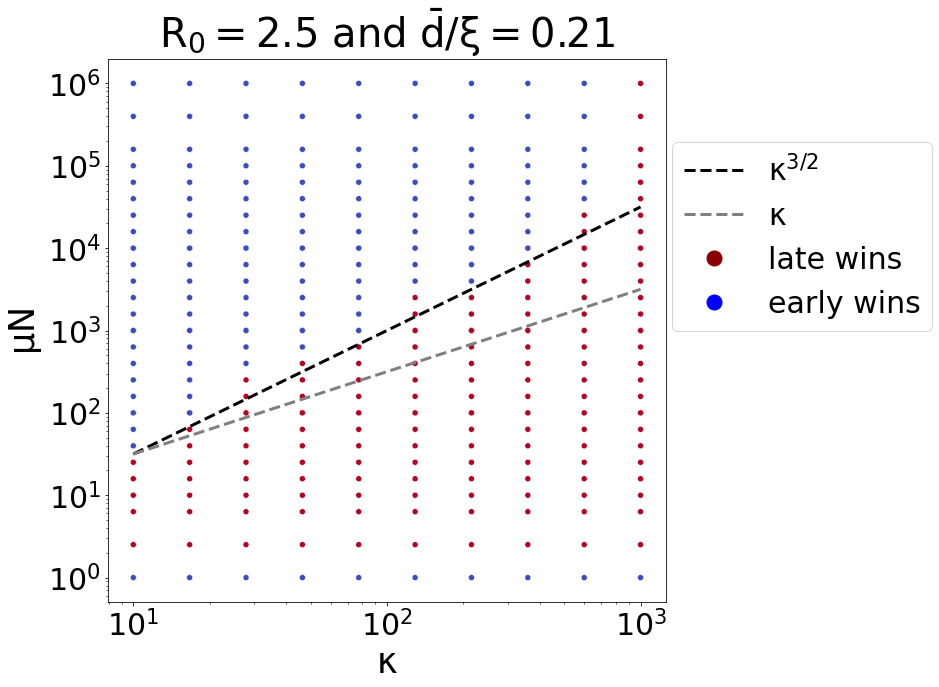

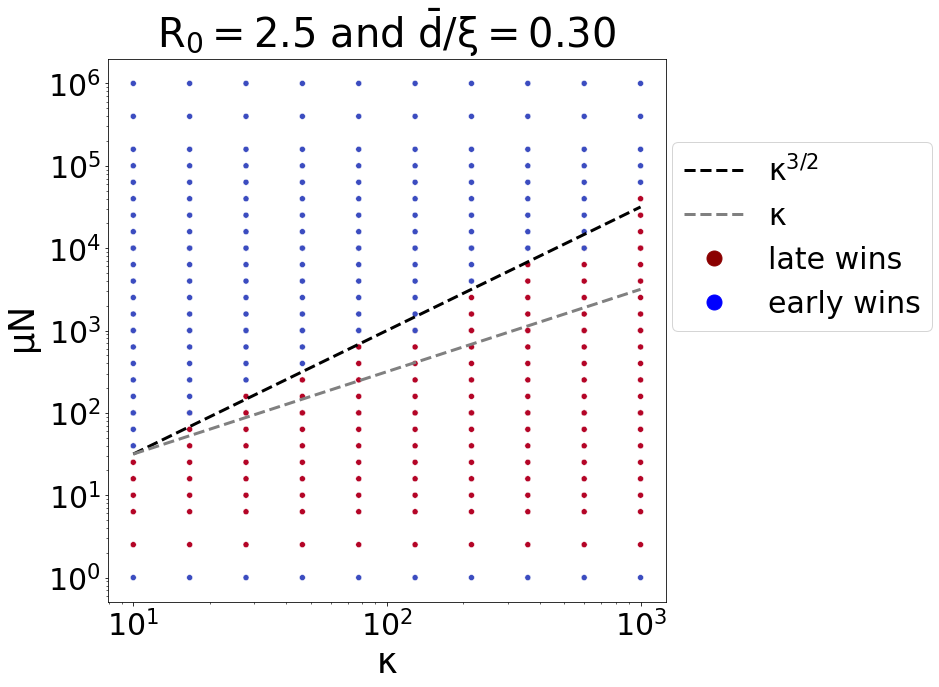

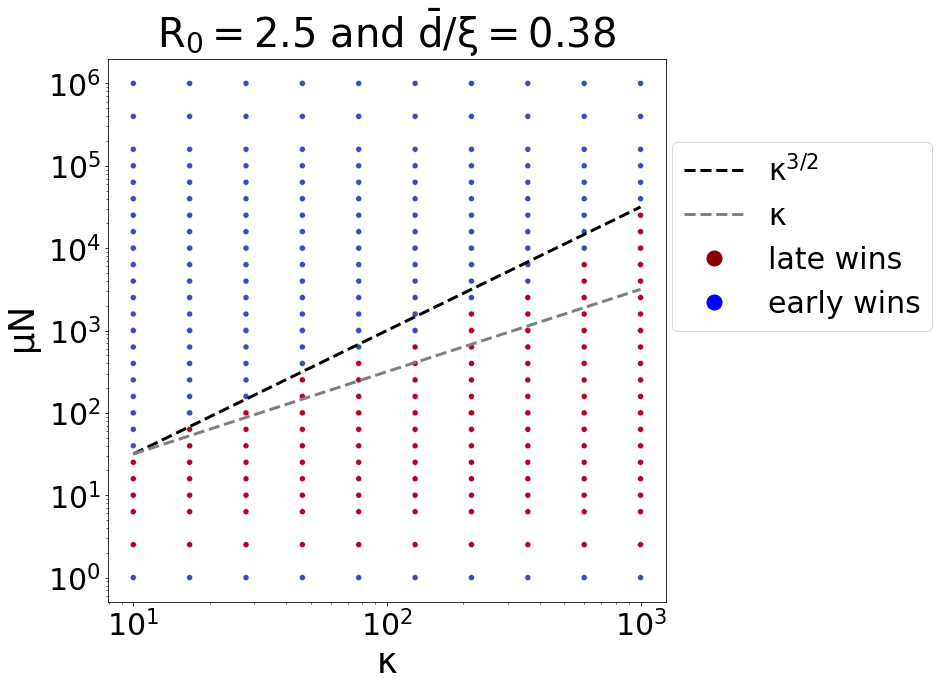

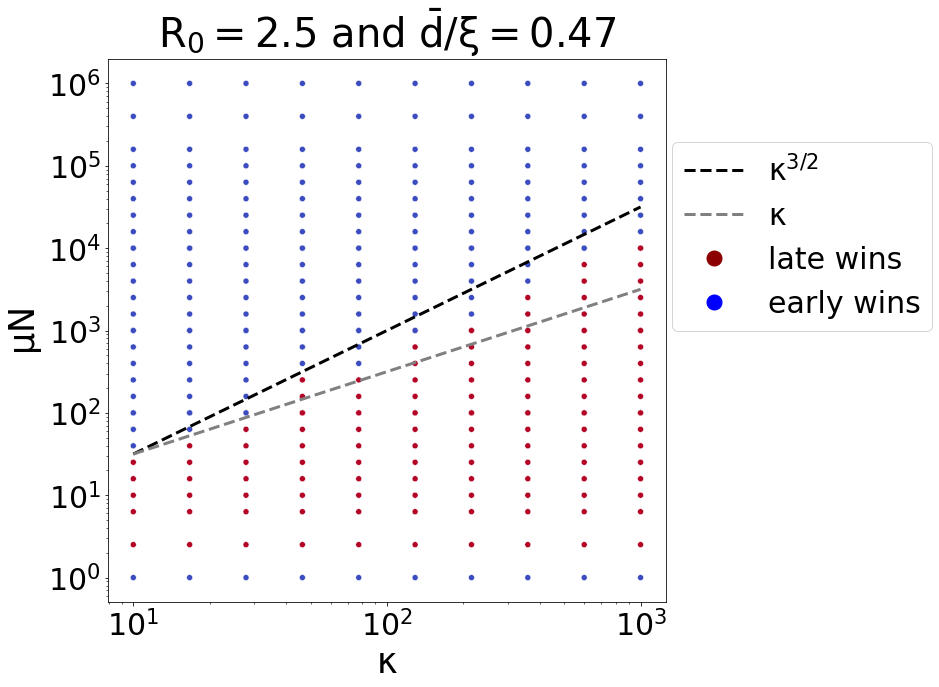

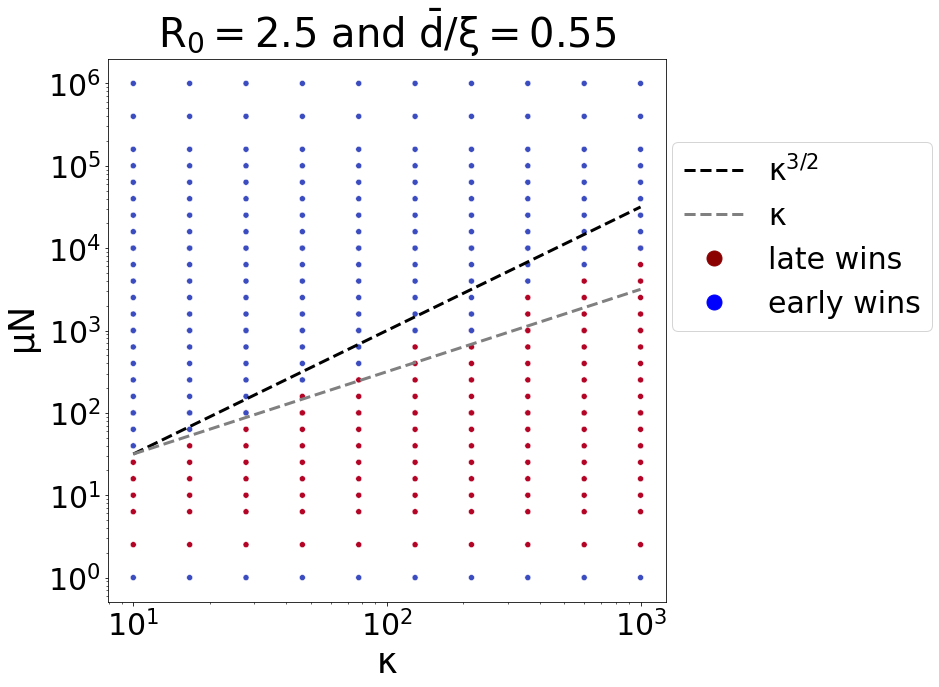

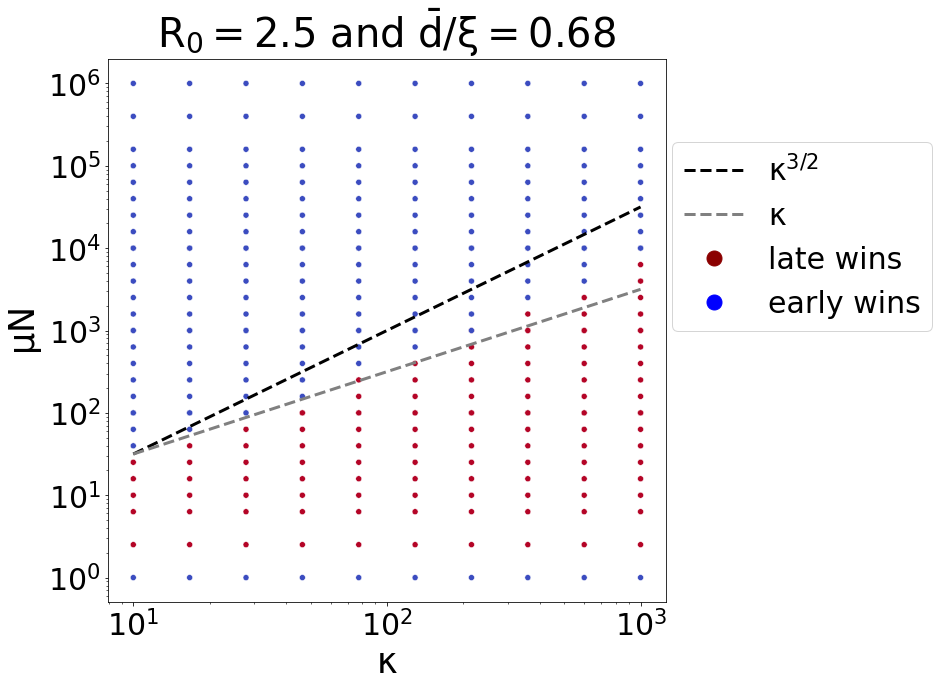

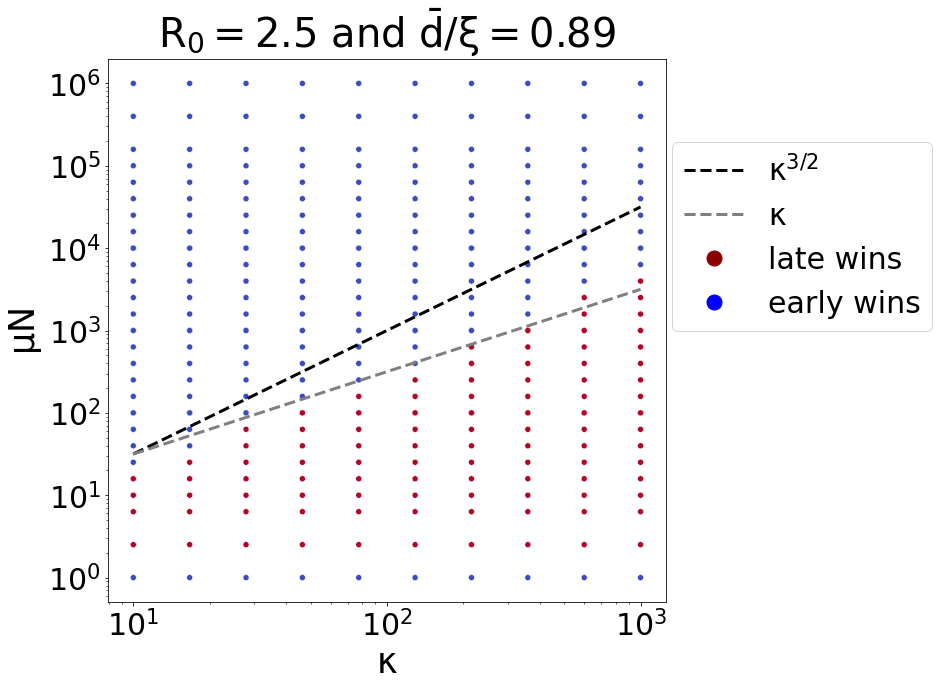

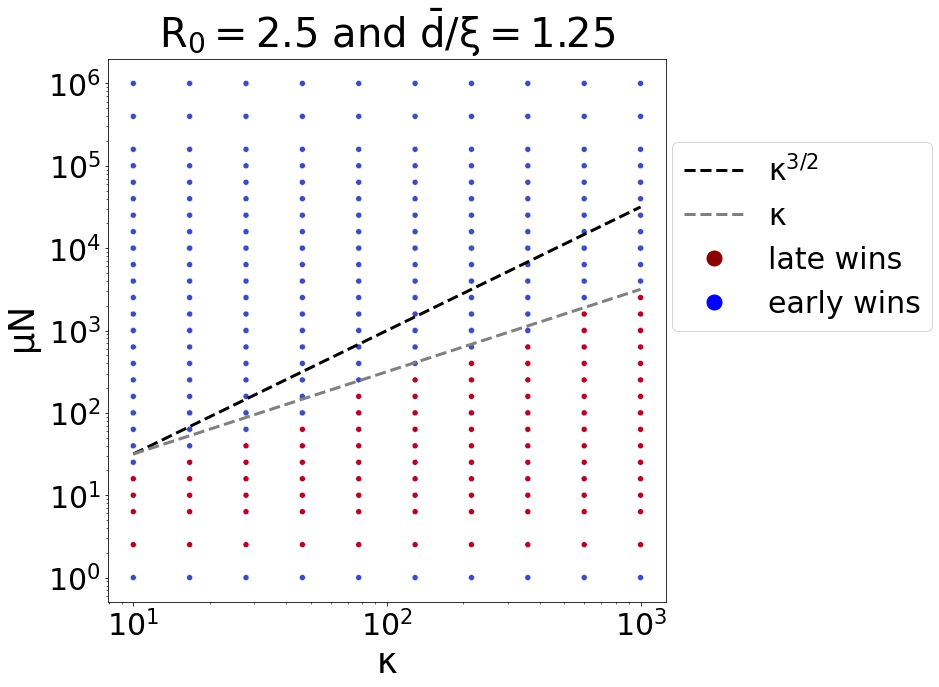

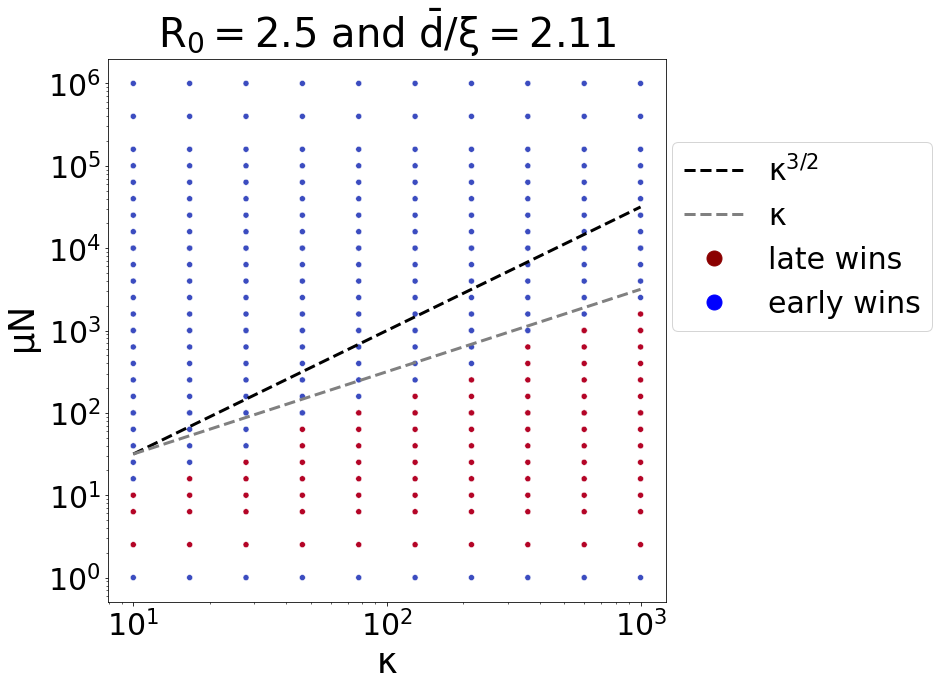

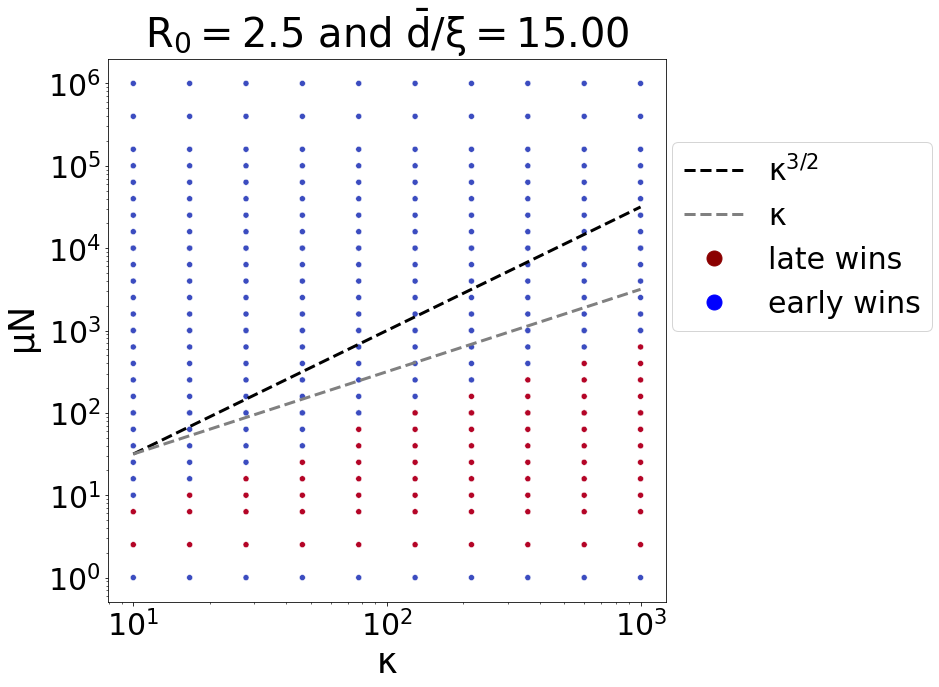

In [22]:
N = 1e10
scaled_dbar = np.sort(pd_df['scaled_dbar'].unique())
R0 = 2.5

for scaled_dbar in scaled_dbar[::10]:
    fig,ax= plt.subplots(figsize=(10,10))
    pd_plot = sns.scatterplot(data=pd_df.query(f'R0=={R0} and scaled_dbar=={scaled_dbar}'), x='kappa', y='muN', hue='pd', ax=ax, palette='coolwarm', legend=False)
    ax.plot(kappa_sweeps, kappa_sweeps**1.5, color='black', linestyle='--', label=r'$\kappa^{3/2}$')
    ax.plot(kappa_sweeps, kappa_sweeps *  kappa_sweeps[0]**.5 , color='grey', linestyle='--', label=r'$\kappa$')

    handles = [Line2D([0], [0], linestyle='--', color='black', label=r'$\kappa^{3/2}$'), Line2D([0], [0], linestyle='--', color='grey', label=r'$\kappa$'), 
               Line2D([0], [0], linestyle='', marker='o', color='darkred', label='late wins', markerfacecolor='darkred', markersize=15),
                Line2D([0], [0], linestyle='', marker='o', color='blue', label='early wins', markerfacecolor='blue', markersize=15)]
    ax.legend(handles=handles, loc=(1.01,0.5), fontsize=30)

    ax.set_xlabel(r'$\kappa$')
    ax.set_ylabel(r'$\mu N$')
    ax.set_title(rf'$R_0={R0}$ and $\bar{{d}}/\xi={scaled_dbar:.2f}$')
    ax.set_yscale('log')
    ax.set_xscale('log')

In [23]:
@jit(nopython=True)
def I_t_numba(fit, t_lim, dt):

    L = int(np.round(t_lim/dt))
    I_t = np.zeros(L)    
    for i in range(L):
        Q=0
        t1 = dt*i
        rho_t = dt*(np.cumsum(-fit[i:L+1])- (-fit[i]) )
        for j in range(i,L):
            S = dt*np.exp(rho_t[j-i])            
            Q+=S
        I_t[i]=Q
    return I_t


def p_surv(fit,t_lim,dt):
    I_t =np.array(I_t_numba(fit,t_lim,dt))
    return 1- I_t/(1+I_t)
            

def product_sum_probas(S,I, t_lim, R0, kappa,xi,ds,dt, N, p_alpha):
    x,y = S/N, I/N
    z = 1-x-y
    
    fit_d = lambda d: R0/(1+y*kappa) * ( x + (1- np.exp(-d/xi))*z )-1

    product_sum = 0
    
    L = len(ds)
    for i in range(L):
        d= ds[i]
        fit = fit_d(d)
        p_surv_t = p_surv(fit,t_lim, dt)
        product_sum +=funcs.rho_d(d=d,p_alpha=p_alpha )*p_surv_t
    
    return product_sum

def product_sum_probas_adiabatic(S,I, t_lim, R0, kappa,xi,ds,dt, N, p_alpha):
    x,y = S/N, I/N
    z = 1-x-y
    
    fit_d = lambda d: R0/(1+y*kappa) * ( x + (1- np.exp(-d/xi))*z )-1

    product_sum = 0
    
    L = len(ds)
    for i in range(L):
        d= ds[i]
        fit = fit_d(d)
        p_surv_t = np.maximum(0,1 - 1/(1+fit))
        product_sum +=funcs.rho_d(d=d,p_alpha=p_alpha )*p_surv_t
    
    return product_sum

In [24]:
import scipy.optimize as so

def model_w_params(R0, N, k): 
    def model(y,t):
        S = y[0]
        I = y[1]
        R0_eff = R0/(1+k*I/(N))
        dSdt = - R0_eff * S*I/N 
        dIdt =  R0_eff * S*I/N -I
        return [dSdt,dIdt]
    return model

def find_x_inf(R0,k):
    if k>0:
        c = (R0-k+R0*k)/(k*(R0-k))
        rho = 1/(R0/k)
        y_x = lambda x: c*x**rho + x/(rho-1) - 1/k

        roots = so.fsolve(y_x, 0)
        return roots[0]
    else:
        return np.real(-1/R0*sps.lambertw(-R0*np.exp(-R0)))

def integrate_trajectory(R0,kappa,N, I0=10):
    S0 = N-I0
    y0 = [S0,I0]
    x_inf = find_x_inf(R0,kappa)
    
    t_end = 1.5*np.log(N)* (1/(R0-1) + 1/(1-R0*x_inf))
    ts = np.linspace(0, t_end,5000)
    dt = ts[1]-ts[0]
    y = odeint(model_w_params(R0,N,kappa),y0,ts).T

    return ts, y

def get_exp_num_established(R0, kappa, p_alpha,xi, N):
    ts, solution= integrate_trajectory(R0,kappa,N)
    ds = np.arange(1,int(10/p_alpha)+1)

    S,I = solution
    t2 = ts[-1]
    dt = ts[1]-ts[0]
    idx_times = ts<t2
    prod_sum_prob = product_sum_probas(S,I, t2, R0, kappa,xi,ds,dt, N, p_alpha)
    try:
        exp_number_est_mutants = dt*np.sum(prod_sum_prob*I[idx_times])
    except ValueError:
        idx_times = ts<=t2
        exp_number_est_mutants = dt*np.sum(prod_sum_prob*I[idx_times])
        
    return exp_number_est_mutants

def get_exp_num_established_adiabatic(R0, kappa, p_alpha,xi, N):
    ts, solution= integrate_trajectory(R0,kappa,N)
    ds = np.arange(1,int(10/p_alpha)+1)

    S,I = solution
    t2 = ts[-1]
    dt = ts[1]-ts[0]
    idx_times = ts<t2
    prod_sum_prob = product_sum_probas_adiabatic(S,I, t2, R0, kappa,xi,ds,dt, N, p_alpha)
    try:
        exp_number_est_mutants = dt*np.sum(prod_sum_prob*I[idx_times])
    except ValueError:
        idx_times = ts<=t2
        exp_number_est_mutants = dt*np.sum(prod_sum_prob*I[idx_times])
        
    return exp_number_est_mutants

In [25]:
kappa_sweeps

array([  10.        ,   16.68100537,   27.82559402,   46.41588834,
         77.42636827,  129.1549665 ,  215.443469  ,  359.38136638,
        599.48425032, 1000.        ])

In [26]:
# R0_sweeps = sweeps[0] R0 =2.5
kappa_sweeps= sweeps[1]
mu_sweeps = sweeps[2]
N_sweeps = sweeps[3]
# dbar_sweeps = sweeps[4]# dbar = 10
# xi_sweeps = sweeps[5]# xi = 30

R0 = 2.5
dbar= 10
xi_s_pd = [20,30,50]

if os.path.exists(os.getcwd()+'/exp_t_dep_nums_df_modulo_mu.feather'):
    exp_t_dep_nums_df_modulo_mu = pd.read_feather(os.getcwd()+'/exp_t_dep_nums_df_modulo_mu.feather')
else:
    exp_t_dep_nums_df_modulo_mu = pd.DataFrame.from_dict({i:(R0, kappa,  N, dbar, xi, get_exp_num_established(R0=R0, kappa = kappa, p_alpha=1/dbar,xi = xi, N=N)) for i, (kappa,N,xi) in enumerate(funcs.product( kappa_sweeps, N_sweeps, xi_s_pd))}, orient='index', columns=['R0', 'kappa', 'N', 'dbar', 'xi','exp_num_est_mutants_mod_mu'])
    exp_t_dep_nums_df_modulo_mu.to_feather(os.getcwd()+'/exp_t_dep_nums_df_modulo_mu.feather')


In [27]:
evolution_pd = pd.DataFrame(columns=['R0', 'kappa', 'N', 'mu', 'dbar', 'xi','exp_num_est_mutants_mod_mu'])

for mu in mu_sweeps:
    evolution_pd = pd.concat([evolution_pd, exp_t_dep_nums_df_modulo_mu.assign(mu=mu)], ignore_index=True)
    
evolution_pd['exp_num_est_mutants'] = evolution_pd['exp_num_est_mutants_mod_mu']*evolution_pd['mu']
evolution_pd['p_evo']= 1- np.exp(-evolution_pd['exp_num_est_mutants'])
evolution_pd['scaled_dbar'] = evolution_pd['dbar']/evolution_pd['xi']
evolution_pd['scaled_dbar'] = np.round(evolution_pd['scaled_dbar'].astype(float),1)
evolution_pd['muN'] = evolution_pd['mu']*evolution_pd['N']

In [28]:
kappa_sweeps_with_zero = np.logspace(0,3,10)
kappa_sweeps_with_zero = np.concatenate(([0],kappa_sweeps_with_zero))

if os.path.exists(os.getcwd()+'/exp_t_dep_nums_df_modulo_mu_with_zero.feather'):
    exp_t_dep_nums_df_modulo_mu_with_zero = pd.read_feather(os.getcwd()+'/exp_t_dep_nums_df_modulo_mu_with_zero.feather')
else:
    exp_t_dep_nums_df_modulo_mu_with_zero = pd.DataFrame.from_dict({i:(R0, kappa,  N, dbar, xi, get_exp_num_established(R0=R0, kappa = kappa, p_alpha=1/dbar,xi = xi, N=N)) for i, (kappa,N,xi) in tqdm(enumerate(funcs.product( kappa_sweeps_with_zero, N_sweeps, xi_s_pd)))}, orient='index', columns=['R0', 'kappa', 'N', 'dbar', 'xi','exp_num_est_mutants_mod_mu'])
    exp_t_dep_nums_df_modulo_mu_with_zero.to_feather(os.getcwd()+'/exp_t_dep_nums_df_modulo_mu_with_zero.feather')

evolution_pd_with_zero = pd.DataFrame(columns=['R0', 'kappa', 'N', 'mu', 'dbar', 'xi','exp_num_est_mutants_mod_mu'])
for mu in mu_sweeps:
    evolution_pd_with_zero = pd.concat([evolution_pd_with_zero, exp_t_dep_nums_df_modulo_mu_with_zero.assign(mu=mu)], ignore_index=True)


evolution_pd_with_zero['exp_num_est_mutants'] = evolution_pd_with_zero['exp_num_est_mutants_mod_mu']*evolution_pd_with_zero['mu']
evolution_pd_with_zero['p_evo'] = 1- np.exp(-evolution_pd_with_zero['exp_num_est_mutants'])
evolution_pd_with_zero['scaled_dbar'] = evolution_pd_with_zero['dbar']/evolution_pd_with_zero['xi']
evolution_pd_with_zero['scaled_dbar'] = np.round(evolution_pd_with_zero['scaled_dbar'].astype(float),1)
evolution_pd_with_zero['muN'] = evolution_pd_with_zero['mu']*evolution_pd_with_zero['N']


In [29]:
muNs

NameError: name 'muNs' is not defined

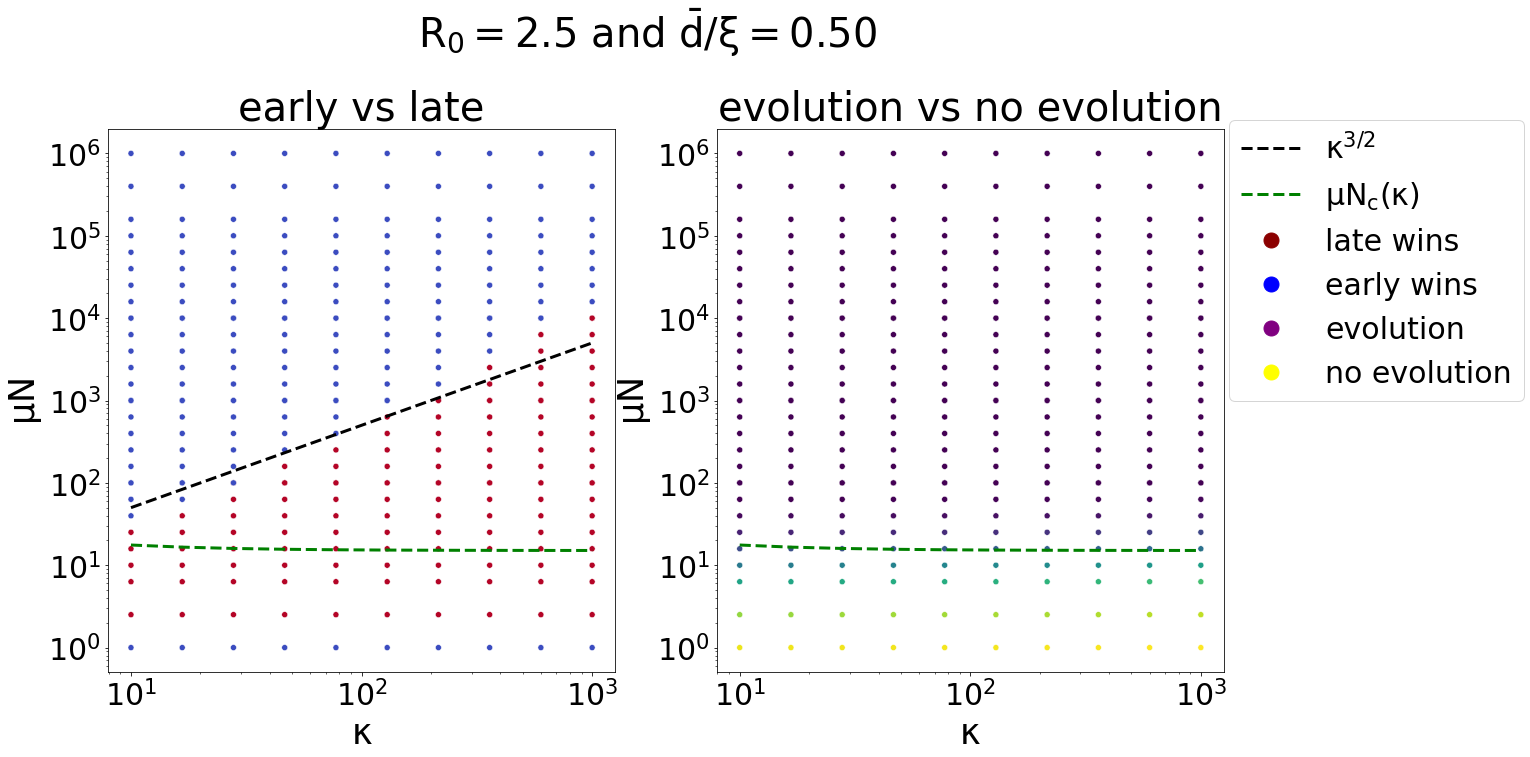

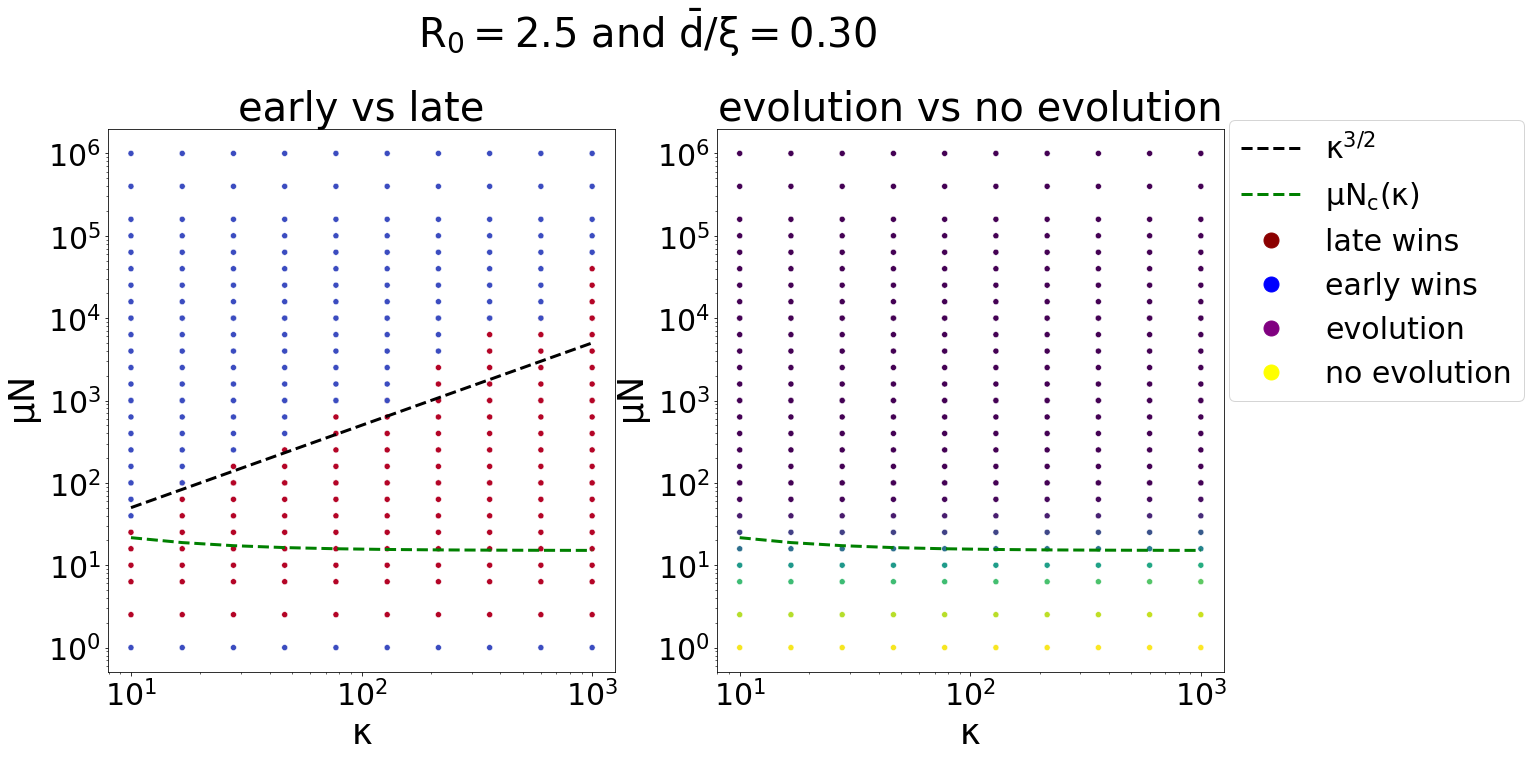

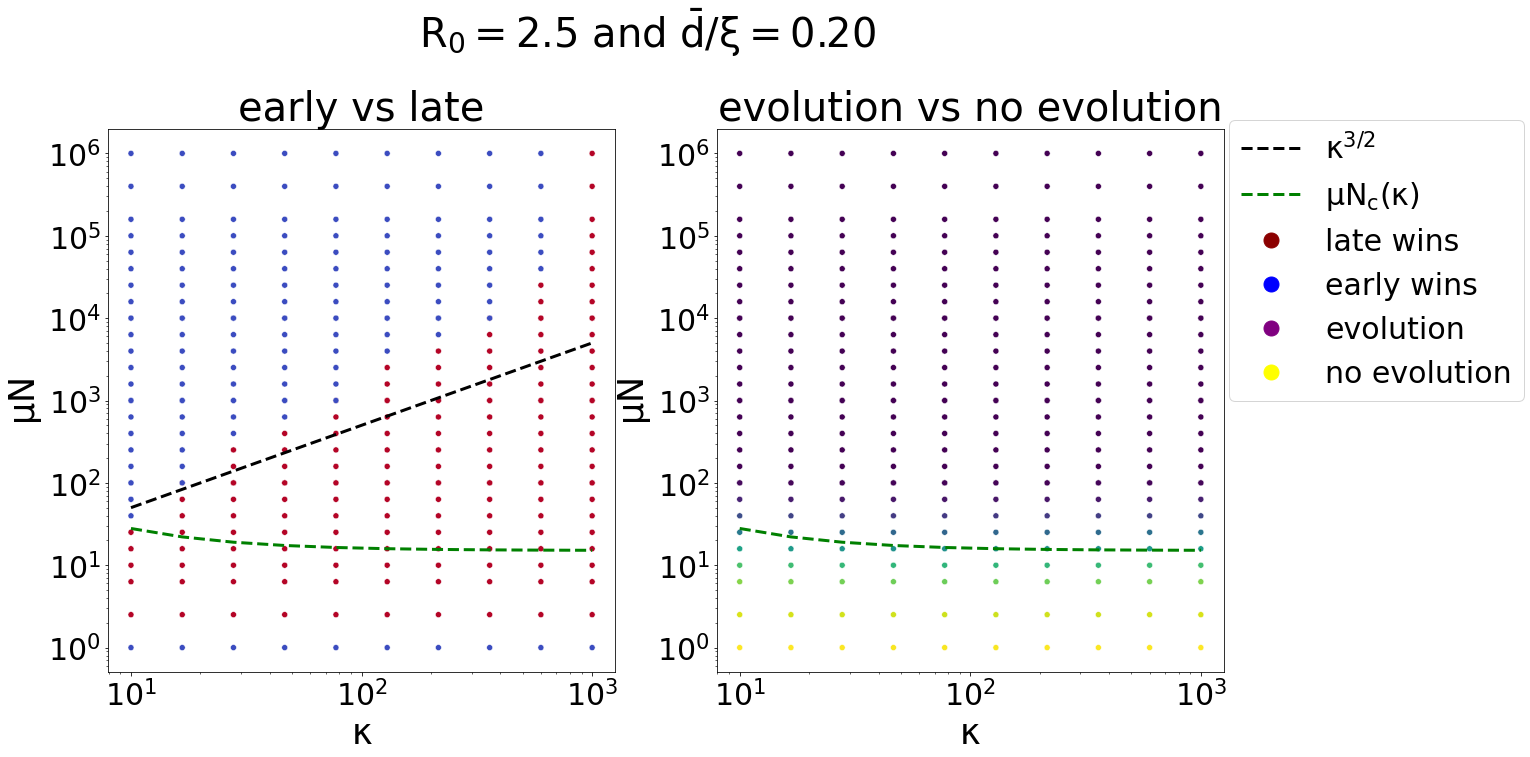

In [36]:
scaled_dbar = np.sort(pd_df['scaled_dbar'].unique())
R0 = 2.5

scaled_dbar = .2
for scaled_dbar in evolution_pd['scaled_dbar'].unique():
    xi = 10/scaled_dbar

    fig,ax= plt.subplots(1,2,figsize=(20,10))

    ax[0].plot(kappa_sweeps, 2* R0* kappa_sweeps, color='black', linestyle='--', label=r'$\kappa$')
    pd_plot = sns.scatterplot(data=pd_df.query(f'R0=={R0}and scaled_dbar=={scaled_dbar}'), x='kappa', y='muN', hue='pd', ax=ax[0], palette='coolwarm', legend=False)


    ax[0].set_xlabel(r'$\kappa$')
    ax[0].set_ylabel(r'$\mu N$')

    ax[0].set_yscale('log')
    ax[0].set_xscale('log')

    #now the same for evolution_pd dataferame
    # ax[1].plot(kappa_sweeps, kappa_sweeps**1.5, color='black', linestyle='--', label=r'$\kappa^{3/2}$')

    handles = [Line2D([0], [0], linestyle='--', color='black', label=r'$\kappa^{3/2}$')]

    muNs= np.sort(evolution_pd.query(f'R0=={R0}and scaled_dbar=={scaled_dbar:.1f}')['muN'].unique()).astype(float)
    # kc = 1/(np.exp((scaled_dbar*np.log(muNs) + 1/xi - np.log(R0/(R0-1)))/(1-scaled_dbar))  -(R0-1)/R0 )
    # ax[1].plot(kc, muNs )

    #muNc = ((R0/(-1 + R0))**(1/\[Delta])*((R0*\[Kappa])/(R0 - \[Kappa] + R0*\[Kappa]))**((-1 + \[Delta])/\[Delta]))/E**(1/(\[Delta]*\[Xi]))
    muNc = lambda kappa,scaled_dbar,R0,xi: ((R0/(-1 + R0))**(1/scaled_dbar)*((R0*kappa)/(R0 - kappa + R0*kappa))**((-1 + scaled_dbar)/scaled_dbar))/np.exp(1/(scaled_dbar*xi))
    ax[1].plot(kappa_sweeps, 10*muNc(kappa_sweeps,scaled_dbar,R0,xi), color='green', linestyle='--')
    ax[0].plot(kappa_sweeps, 10*muNc(kappa_sweeps,scaled_dbar,R0,xi), color='green', linestyle='--')

    handles = [Line2D([0], [0], linestyle='--', color='black', label=r'$\kappa^{3/2}$'),
            Line2D([0], [0], linestyle='--', color='green', label=r'$\mu N_c (\kappa)$')]
    handles+= [Line2D([0], [0], linestyle='', marker='o', color='darkred', label='late wins', markerfacecolor='darkred', markersize=15),
                Line2D([0], [0], linestyle='', marker='o', color='blue', label='early wins', markerfacecolor='blue', markersize=15),
                Line2D([0], [0], linestyle='', marker='o', color='purple', label='evolution', markersize=15),
                Line2D([0], [0], linestyle='', marker='o', color='yellow', label='no evolution', markersize=15)]

    ax[1].legend(handles=handles, loc=(1.01,0.5), fontsize=30)

    ax[1].set_yscale('log')
    ax[1].set_xscale('log')
    ax[1].set_xlabel(r'$\kappa$')
    ax[1].set_ylabel(r'$\mu N$')
    pd_plot2 = sns.scatterplot(data=evolution_pd.query(f'R0=={R0}and scaled_dbar=={scaled_dbar:.1f}'), x='kappa', y='muN', hue='p_evo', ax=ax[1], palette='viridis_r', legend=False)
    
#     ax[1].contour(kappa_sweeps, muNs, evolution_pd.query(f'R0=={R0}and scaled_dbar=={scaled_dbar:.1f}')['p_evo'].values.reshape(len(muNs),-1), levels=[0.5], colors='purple')
    ax[0].set_title(rf'early vs late')
    ax[1].set_title(rf'evolution vs no evolution')
    fig.suptitle(rf'$R_0={R0}$ and $\bar{{d}}/\xi={scaled_dbar:.2f}$',y=1.05)
    plt.savefig(results_folder+f'/early_late_evo_vs_no_evo_R0_{R0}_scaled_dbar_{scaled_dbar:.2f}.svg',bbox_inches='tight')

In [37]:
results_folder

'../results/parameter_runs/Figure4'

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in reciprocal
  if __name__ == '__main__':
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.


Text(0.5, 1.05, '$R_0=2.5$ and $\\bar{d}/\\xi=0.50$')

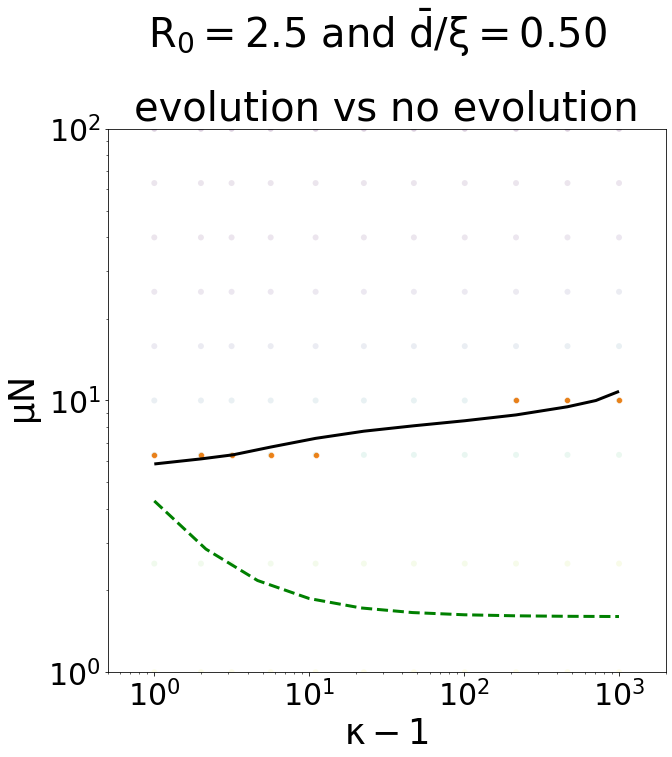

In [32]:
scaled_dbar = .5
fig,ax = plt.subplots(figsize=(10,10))
evolution_pd_with_zero['kappa_plot'] = 1+ evolution_pd_with_zero['kappa']
muNs= np.sort(evolution_pd_with_zero.query(f'R0=={R0}and scaled_dbar=={scaled_dbar:.1f}')['muN'].unique()).astype(float)
# kc = 1/(np.exp((scaled_dbar*np.log(muNs) + 1/xi - np.log(R0/(R0-1)))/(1-scaled_dbar))  -(R0-1)/R0 )
# ax.plot(kc, muNs )

#muNc = ((R0/(-1 + R0))**(1/\[Delta])*((R0*\[Kappa])/(R0 - \[Kappa] + R0*\[Kappa]))**((-1 + \[Delta])/\[Delta]))/E**(1/(\[Delta]*\[Xi]))
muNc = lambda kappa,scaled_dbar,R0,xi: ((R0/(-1 + R0))**(1/scaled_dbar)*((R0*kappa)/(R0 - kappa + R0*kappa))**((-1 + scaled_dbar)/scaled_dbar))/np.exp(1/(scaled_dbar*xi))
ax.plot(kappa_sweeps_with_zero, 1*muNc(kappa_sweeps_with_zero,scaled_dbar,R0,xi), color='green', linestyle='--')


handles = [Line2D([0], [0], linestyle='--', color='black', label=r'$\kappa^{3/2}$'),
        Line2D([0], [0], linestyle='--', color='green', label=r'$\mu N_c (\kappa)$')]
handles+= [Line2D([0], [0], linestyle='', marker='o', color='darkred', label='late wins', markerfacecolor='darkred', markersize=15),
            Line2D([0], [0], linestyle='', marker='o', color='blue', label='early wins', markerfacecolor='blue', markersize=15),
            Line2D([0], [0], linestyle='', marker='o', color='purple', label='evolution', markersize=15),
            Line2D([0], [0], linestyle='', marker='o', color='yellow', label='no evolution', markersize=15)]

# ax.legend(handles=handles, loc=(1.01,0.5), fontsize=30)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\kappa-1$')
ax.set_ylabel(r'$\mu N$')
pd_plot2 = sns.scatterplot(data=evolution_pd_with_zero.query(f'R0=={R0}and scaled_dbar=={scaled_dbar:.1f}'), x='kappa_plot', y='muN', hue='p_evo', ax=ax, palette='viridis_r', legend=False,alpha =.1)             
# ax.contour(kappa_sweeps_with_zero, muNs, evolution_pd_with_zero.query(f'R0=={R0}and scaled_dbar=={scaled_dbar:.1f}')['p_evo'].values.reshape(len(muNs),len(kappa_sweeps_with_zero)), levels=[0.5], colors='purple')
#contour plot of evolution probability
ylim = ax.get_ylim()

mini_df = (evolution_pd_with_zero
           .query(f'R0=={R0} and scaled_dbar=={scaled_dbar:.1f}')
           .groupby(['kappa_plot', 'muN'])
           .mean()
           .reset_index())


muN_vals = mini_df['muN'].unique()
kappa_vals = mini_df['kappa_plot'].unique()
p_evo_vals = mini_df.pivot(index='muN', columns='kappa_plot', values='p_evo').values
ax.contour(kappa_vals, muN_vals, p_evo_vals, levels=[0.5], colors='black')
sns.scatterplot(data=mini_df.query('p_evo>.45 & p_evo<.55'), x='kappa_plot', y='muN', ax=ax, palette=['red'], legend=False, zorder=0)             
# ax[1].set_ylim(ylim)
ax.set_xlim(ax.get_xlim()*np.array([.5,2]))
ax.set_ylim((1,100))
ax.set_title(rf'evolution vs no evolution')
fig.suptitle(rf'$R_0={R0}$ and $\bar{{d}}/\xi={scaled_dbar:.2f}$',y=1.05)

In [ ]:
colors_scaled_dbar

{0.5: array([0.993248, 0.906157, 0.143936, 1.      ]),
 0.3: array([0.128729, 0.563265, 0.551229, 1.      ]),
 0.2: array([0.267004, 0.004874, 0.329415, 1.      ])}

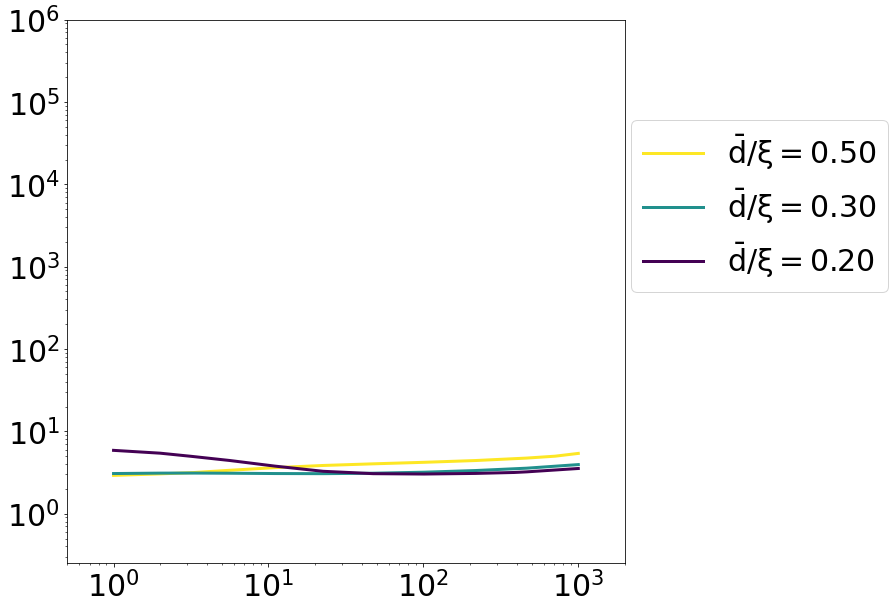

In [ ]:
colors_scaled_dbar= funcs.color_dict(evolution_pd['scaled_dbar'].unique(),plt.cm.viridis_r)
fig,ax= plt.subplots(figsize=(10,10))
for scaled_dbar in evolution_pd['scaled_dbar'].unique():
    mini_df = (evolution_pd_with_zero
           .query(f'R0=={R0} and scaled_dbar=={scaled_dbar:.1f}')
           .groupby(['kappa_plot', 'muN'])
           .mean()
           .reset_index())


    muN_vals = mini_df['muN'].unique()
    kappa_vals = mini_df['kappa_plot'].unique()
    p_evo_vals = mini_df.pivot(index='muN', columns='kappa_plot', values='p_evo').values
    C =ax.contour(kappa_vals, muN_vals*scaled_dbar, p_evo_vals, levels=[0.5],alpha=0)
    Cx, Cy = C.allsegs[0][0].T
    ax.plot(Cx, Cy, color=colors_scaled_dbar[scaled_dbar], label = rf'$\bar{{d}}/\xi={scaled_dbar:.2f}$')
    # sns.scatterplot(data=mini_df.query('p_evo>.45 & p_evo<.55'), x='kappa_plot', y='muN', ax=ax, palette=['red'], legend=False, zorder=0)             
    # ax[1].set_ylim(ylim)
ax.set_xlim(ax.get_xlim()*np.array([.5,2]))
ax.set_ylim(ax.get_ylim()*np.array([.5,2]))
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=(1.01,0.5), fontsize=30)


Text(0.5, 0, '$\\kappa-1$')

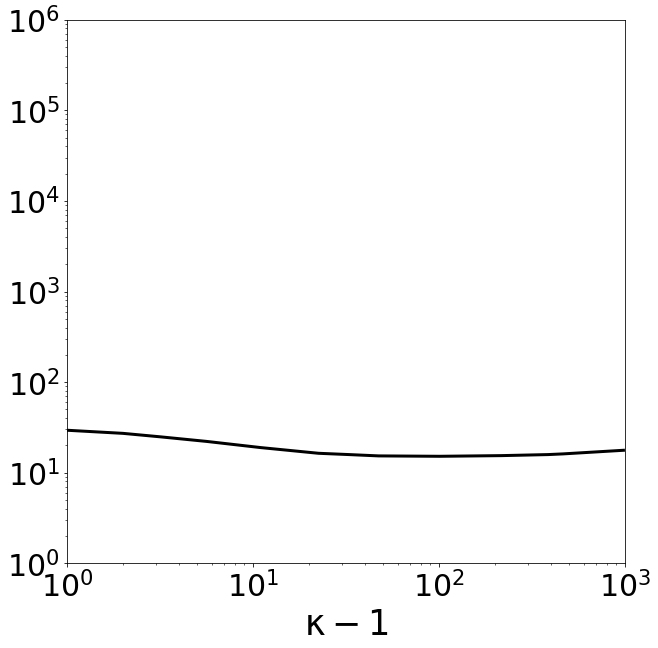

In [ ]:
queried_evo_pd = evolution_pd_with_zero.query(f'R0=={R0}and scaled_dbar=={scaled_dbar:.1f} ')
mini_df = queried_evo_pd[['kappa_plot','muN','p_evo']]
mini_df = mini_df.groupby(['kappa_plot','muN']).mean().reset_index()

muN_vals = []
kappa_vals = []
p_evo_vals = []
for muN in mini_df['muN'].unique():
    muN_vals.append(muN)
    for kappa in mini_df['kappa_plot'].unique():
        kappa_vals.append(kappa)
        p_evo_vals.append(mini_df.query(f'muN=={muN} and kappa_plot=={kappa}')['p_evo'].values[0])

muN_vals = np.array(muN_vals)
kappa_vals = np.unique(np.array(kappa_vals))

p_evo_vals = np.array(p_evo_vals)
p_evo_vals = p_evo_vals.reshape(len(muN_vals),-1)
#sort p_evo_vals by kappa and muN
idx = np.argsort(kappa_vals)
kappa_vals = kappa_vals
p_evo_vals = p_evo_vals[:,idx]

idx = np.argsort(muN_vals)
muN_vals = muN_vals[idx]
p_evo_vals = p_evo_vals[idx,:]

fig,ax = plt.subplots(figsize=(10,10))
ax.contour(kappa_vals, muN_vals, p_evo_vals, levels=[0.5], colors='black')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\kappa-1$')


Text(0.5, 0, '$\\kappa-1$')

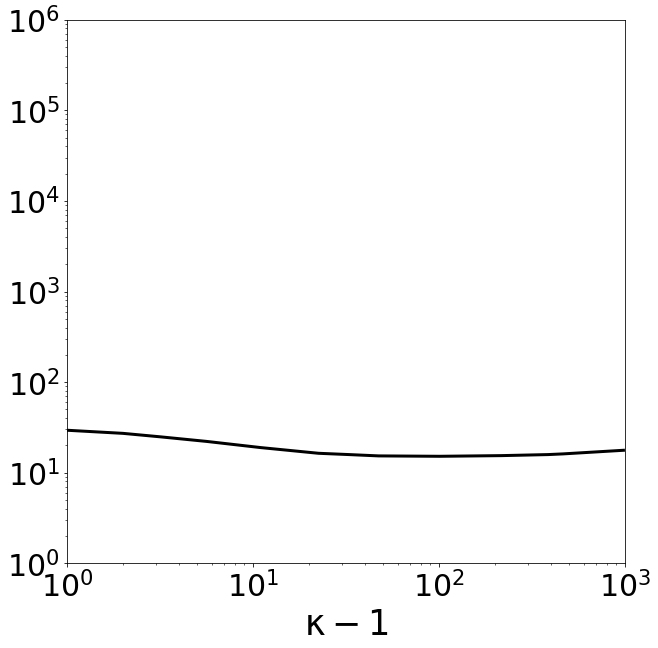

In [ ]:
mini_df = (evolution_pd_with_zero
           .query(f'R0=={R0} and scaled_dbar=={scaled_dbar:.1f}')
           .groupby(['kappa_plot', 'muN'])
           .mean()
           .reset_index())


muN_vals = mini_df['muN'].unique()
kappa_vals = mini_df['kappa_plot'].unique()
p_evo_vals = mini_df.pivot(index='muN', columns='kappa_plot', values='p_evo').values

# idx_kappa = np.argsort(kappa_vals)
# idx_muN = np.argsort(muN_vals)
# kappa_vals = kappa_vals[idx_kappa]
# muN_vals = muN_vals[idx_muN]
# p_evo_vals = p_evo_vals[idx_muN, :]
# p_evo_vals = p_evo_vals[:, idx_kappa]

fig,ax = plt.subplots(figsize=(10,10))
ax.contour(kappa_vals, muN_vals, p_evo_vals, levels=[0.5], colors='black')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\kappa-1$')

In [ ]:
muN_vals = np.array(mu_vals)

In [ ]:
p_evo_vals.shape, muN_vals.shape, kappa_vals.shape


((27, 11), (27,), (297,))

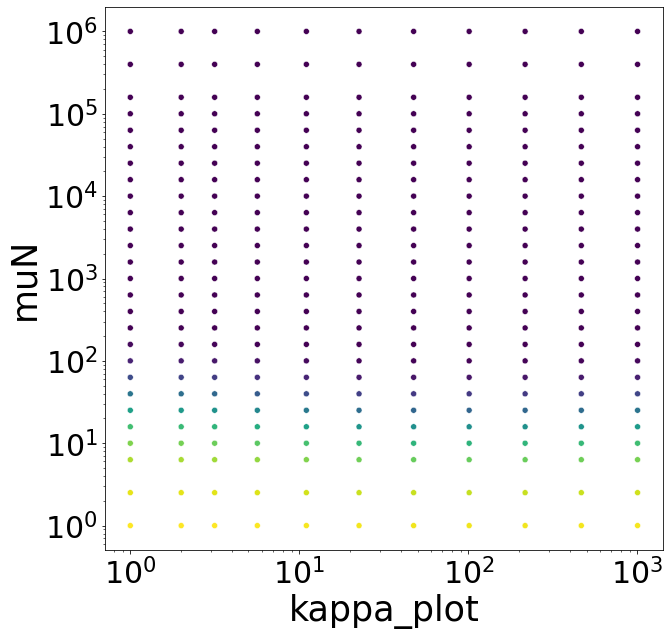

In [ ]:
fig,ax= plt.subplots(figsize=(10,10))
sns.scatterplot(mini_df, x='kappa_plot', y='muN', hue='p_evo', palette='viridis_r', legend=False,ax=ax, vmin = 0, vmax=1)
ax.set_yscale('log')
ax.set_xscale('log')

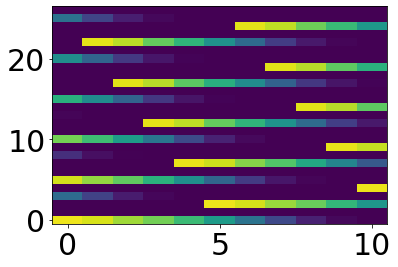

In [ ]:
#reduce mini_df only to unique combinations of parameters by averaging

mini_df['p_evo'].shape, mini_df['kappa_plot'].unique().shape, mini_df['muN'].unique().shape
plt.imshow(np.array(mini_df["p_evo"].values.tolist()).astype('float').reshape(len(mini_df['muN'].unique()),-1), aspect='auto', origin='lower', cmap='viridis_r', vmin = 0, vmax=1)


In [ ]:
mini_df

,kappa_plot,muN,p_evo
0,1.0,1.000000,0.024035
1,1.0,2.511886,0.059281
2,1.0,6.309573,0.142301
3,1.0,10.000000,0.211909
4,1.0,15.848932,0.319944
...,...,...,...
292,1001.0,63095.734448,1.000000
293,1001.0,100000.000000,1.000000
294,1001.0,158489.319246,1.000000
295,1001.0,398107.170553,1.000000


In [ ]:
evolution_pd_with_zero['exp_num_est_mutants_mod_muN'] = evolution_pd_with_zero['exp_num_est_mutants_mod_mu']/evolution_pd_with_zero['N']

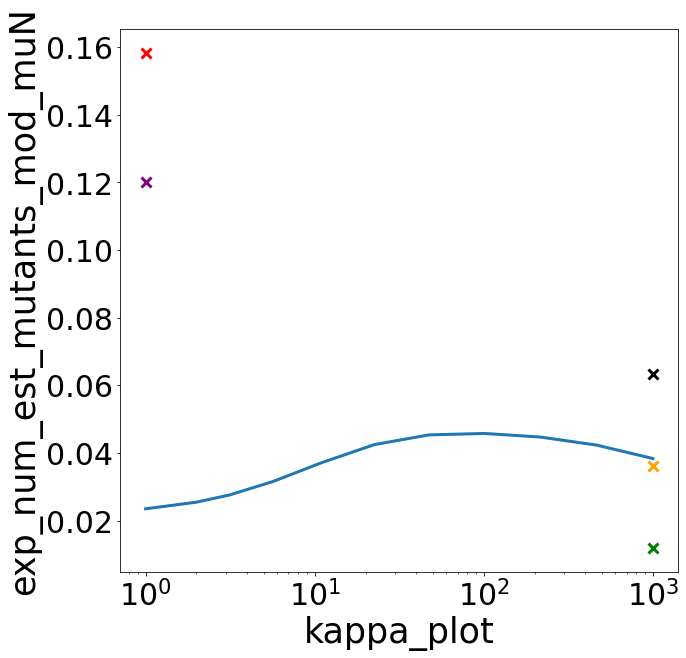

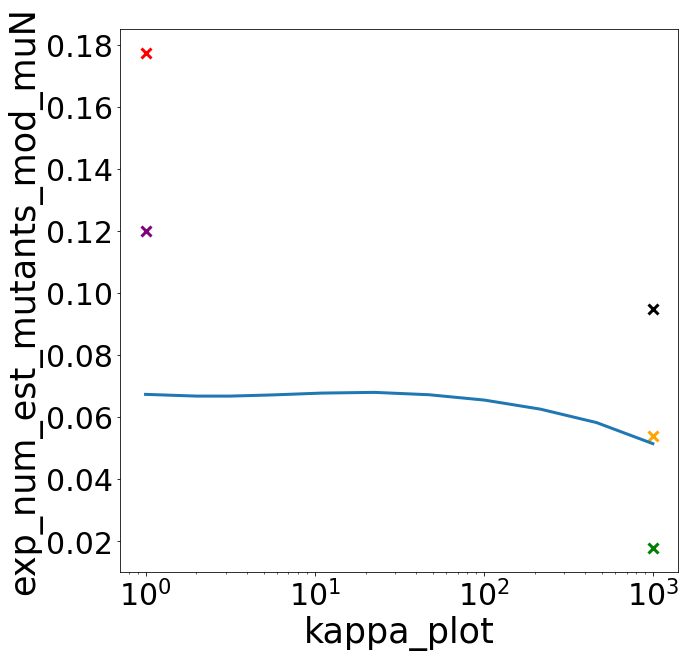

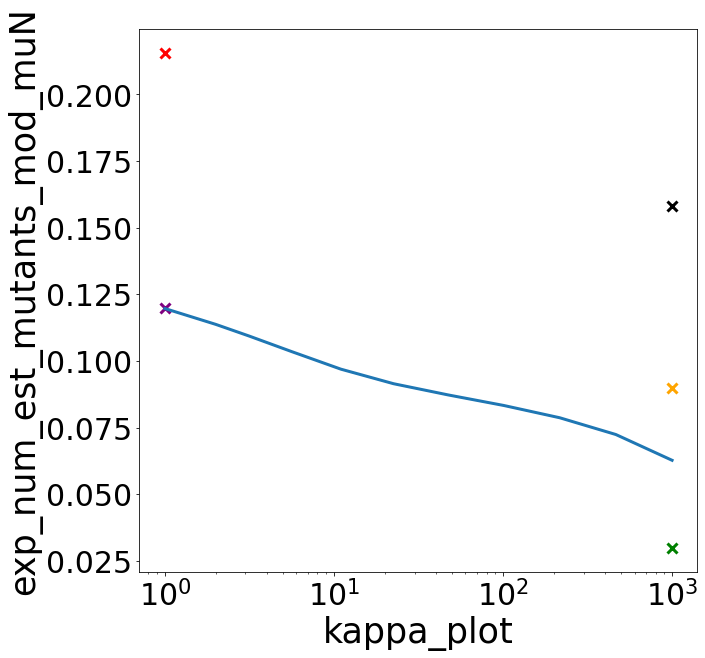

In [ ]:
    
N = 1e8

for scaled_dbar in [.2,.3,.5]:
    fig,ax = plt.subplots(figsize=(10,10))
    sns.lineplot(evolution_pd_with_zero.query(f'R0=={R0}and scaled_dbar=={scaled_dbar:.1f} and N == {N}'), x='kappa_plot', y='exp_num_est_mutants_mod_muN',   legend=False)
    
    limval =  scaled_dbar* (np.log(R0)- (R0-1)/R0) - (-1 + R0)**2 *scaled_dbar/(R0*N)
    limval2 = scaled_dbar*((R0-1)/R0)**2 /2
    limvalLin =  scaled_dbar/6 * (R0-1)**2/R0**2

    zeroval = (R0-1)/(2* R0**2)
    zeroval_with_late = zeroval+ scaled_dbar*(1/R0-np.exp(-R0))*(R0-1)/R0


    ax.scatter(kappa_sweeps_with_zero[-1], limval, color='black', marker='x', s=100)
    ax.scatter(kappa_sweeps_with_zero[-1], limval2, color='orange', marker='x', s=100)
    ax.scatter(kappa_sweeps_with_zero[-1], limvalLin, color='green', marker='x', s=100)
    ax.scatter(kappa_sweeps_with_zero[1], zeroval, color='purple', marker='x', s=100)
    ax.scatter(kappa_sweeps_with_zero[1], zeroval_with_late, color='red', marker='x', s=100)
    # ax.set_yscale('log')
    ax.set_xscale('log')

In [ ]:
evolution_pd_with_zero['muN'].unique().shape ,evolution_pd_with_zero['kappa'].unique().shape , kappa_sweeps_with_zero.shape

((27,), (11,), (11,))

In [ ]:
27*11

297